In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#Reading in data
# ==============================================================================
solar1=pd.read_csv('Solar 1.csv')

In [7]:
#Converting to Datetime objects
# ==============================================================================
solar1['datetime']=pd.to_datetime(solar1['datetime'], format='%Y-%m-%d %H:%M:%S')
solar1= solar1.set_index('datetime')
solar1= solar1.asfreq('H')

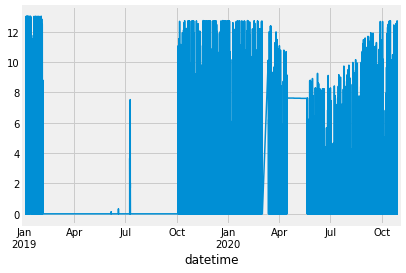

In [8]:
solar1['series_value'].plot()

In [15]:
#Split Train-Val for Solar1
# ==============================================================================
start_train='2019-10-01 00:00'
end_train='2020-06-01 00:00'
start_val='2020-06-01 01:00'
end_val='2020-07-31 23:00'
start_test='2020-08-01 00:00'

solar1train=solar1.loc[start_train:end_train, :]
solar1val=solar1.loc[start_val:end_val, :]
solar1test=solar1.loc[start_test:, :]

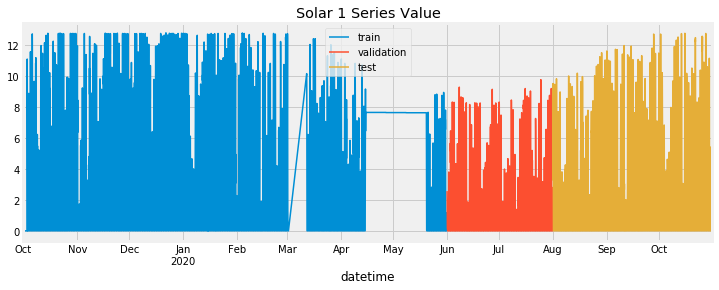

In [16]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar1train['series_value'].plot(ax=ax, label='train')
solar1val['series_value'].plot(ax=ax, label='validation')
solar1test['series_value'].plot(ax=ax, label='test')
ax.set_title('Solar 1 Series Value')
ax.legend();

In [17]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-23 17:27:36 
Last fit date: None 
Skforecast version: 0.4.3 

In [19]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = solar1.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar1train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:12,  1.17s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:13,  1.38s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:04<00:12,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:12,  1.58s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:07<00:10,  1.50s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:09<00:10,  1.67s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:10<00:07,  1.55s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:12<00:06,  1.55s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:13<00:04,  1.45s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:15<00:03,  1.50s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:16<00:01,  1.44s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:13,  1.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:14,  1.48s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:04<00:13,  1.46s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:06<00:12,  1.58s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:07<00:11,  1.59s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:09<00:10,  1.72s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:10<00:07,  1.58s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:12<00:06,  1.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:13<00:04,  1.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:15<00:03,  1.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:17<00:01,  1.53s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:14,  1.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:14,  1.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:04<00:12,  1.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:06<00:13,  1.64s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:07<00:10,  1.56s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:09<00:10,  1.72s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:10<00:07,  1.53s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:12<00:06,  1.50s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:13<00:04,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:15<00:02,  1.46s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:16<00:01,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:01<00:11,  1.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:12,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:10,  1.18s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:10,  1.34s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:09,  1.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:08,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:09<00:06,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:10<00:00, 17.70s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 3.5045907242737693



In [20]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
37                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
39                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
42                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
31  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
41                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
44                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
22  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params    metric  \
37  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  3.504591   
39  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  3.783258   
42  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  3.823584   
31  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  3.956441   
41  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  4.019735   
44  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  4.112171   
22  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  4.138638   
30  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  4.182501   
13  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  4.210846   
1   {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  4.276174   

    learning_rate  max_depth  n_estimators  
37           0.01        3.0         500.0  
39           0.01        5.0         500.0  
42           0.10        3.0         100.0  
31           0.10        3.0         500.0  
41           0.01       10.0         500.0  
44           0.10        5.0         100.0  
22           0.10       10.0         100.0  
30           0.10        3.0         100.0  
13           0.01        3.0         500.0  
1            0.01        3.0         500.0

In [22]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = solar1['series_value'],
    initial_train_size = len(solar1.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False 
    )

print(f"Backtest error: {metric}")

Backtest error: 3.036513074063299


In [23]:
# Predictions
# ==============================================================================
predictions

pred
2020-08-01 00:00:00  5.143787
2020-08-01 01:00:00  6.713882
2020-08-01 02:00:00  7.340634
2020-08-01 03:00:00  7.123275
2020-08-01 04:00:00  6.746063
...                       ...
2020-10-31 19:00:00  0.174577
2020-10-31 20:00:00  0.861327
2020-10-31 21:00:00  2.473686
2020-10-31 22:00:00  4.160517
2020-10-31 23:00:00  5.329304

[2208 rows x 1 columns]

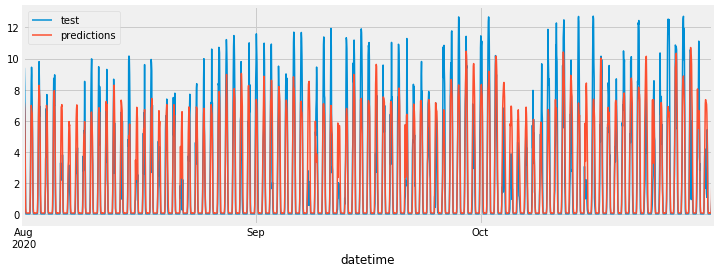

In [25]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar1test['series_value'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [26]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [28]:
solar1test=solar1test.dropna()
solar1train=solar1train.dropna()

In [31]:
LGBM_Mase=mean_absolute_scaled_error(solar1test.reset_index()['series_value'],predictions.reset_index()['pred'],solar1train.reset_index()['series_value'])

In [32]:
# CatBoost Forecasting
# ==============================================================================

In [33]:
# Create Catboost forecaster
# ==============================================================================
cat_forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
                )

cat_forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x0000013DD9C9BF60> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-09-25 00:58:00 
Last fit date: None 
Skforecast version: 0.4.3 

In [34]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = cat_forecaster,
                        y                  = solar1.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar1train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:10<01:58, 10.74s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:20<01:40, 10.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:28<01:22,  9.18s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:38<01:16,  9.62s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:54<01:23, 11.98s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [01:43<02:25, 24.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:51<01:35, 19.17s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [02:00<01:03, 15.88s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [02:08<00:40, 13.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [02:18<00:24, 12.45s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [02:35<00:13, 13.81s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:10<01:54, 10.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:23<01:59, 11.91s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:33<01:41, 11.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:46<01:33, 11.64s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [01:12<01:59, 17.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [02:45<04:16, 42.75s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [02:56<02:41, 32.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [03:08<01:43, 25.94s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [03:19<01:03, 21.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [03:32<00:37, 18.74s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [04:00<00:21, 21.52s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:10<01:59, 10.84s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:23<02:00, 12.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:34<01:44, 11.65s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:48<01:40, 12.51s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [01:19<02:14, 19.20s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [03:25<05:32, 55.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [03:36<03:23, 40.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [03:50<02:09, 32.43s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [04:04<01:20, 26.67s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [04:18<00:45, 22.81s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [04:50<00:25, 25.53s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:06<01:12,  6.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:13<01:09,  6.94s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:20<01:01,  6.86s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:27<00:56,  7.09s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:37<00:56,  8.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [01:01<01:19, 13.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:07<00:55, 11.15s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:15<00:39,  9.87s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:21<00:26,  8.89s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:29<00:16,  8.42s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:39<00:08,  8.83s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [17:41<00:00, 265.37s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 3.3646553434853037



In [35]:
# Backtesting
# ==============================================================================
metric, cat_predictions = backtesting_forecaster(
    forecaster = cat_forecaster,
    y          = solar1['series_value'],
    initial_train_size = len(solar1.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 3.035796961243022


In [36]:
CatBoost_MASE=mean_absolute_scaled_error(solar1test.reset_index()['series_value'],cat_predictions.reset_index()['pred'],solar1train.reset_index()['series_value'])

In [37]:
# Create XGB forecaster
# ==============================================================================
XGB_forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 

In [38]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = XGB_forecaster,
                        y                  = solar1.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar1train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:08<01:37,  8.84s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:17<01:30,  9.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:26<01:18,  8.68s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:35<01:12,  9.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:45<01:04,  9.20s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [01:00<01:06, 11.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:09<00:53, 10.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:19<00:41, 10.34s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:28<00:29,  9.83s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:37<00:19,  9.79s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:46<00:09,  9.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:09<01:43,  9.42s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:19<01:38,  9.86s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:29<01:28,  9.82s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:41<01:25, 10.70s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:51<01:13, 10.53s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [01:10<01:19, 13.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:26<01:11, 14.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [02:06<01:29, 22.43s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [02:23<01:02, 20.67s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [02:37<00:37, 18.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [02:49<00:16, 16.60s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:21<03:58, 21.69s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:35<02:49, 16.97s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:48<02:15, 15.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [01:18<02:50, 21.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [02:44<05:12, 44.63s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [03:17<04:03, 40.64s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [03:32<02:40, 32.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [03:53<01:53, 28.44s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [04:07<01:12, 24.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [04:33<00:49, 24.67s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [04:53<00:23, 23.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:14<02:40, 14.55s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:31<02:41, 16.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:45<02:16, 15.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [01:02<02:05, 15.68s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [01:37<02:40, 22.88s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [01:59<02:15, 22.58s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [03:00<02:55, 35.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [03:24<02:05, 31.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [03:35<01:15, 25.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [03:48<00:42, 21.42s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [04:00<00:18, 18.62s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 5857
Number of observations used for backtesting: 8026
    Number of folds: 223
    Number of steps per fold: 36
    Last fold only includes 34 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-01 14:00:00 -- 2019-09-03 01:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-03 02:00:00 -- 2019-09-04 13:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-04 14:00:00 -- 2019-09-06 01:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-06 02:00:00 -- 2019-09-07 13:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2019-09-01 13:00:00
    Validation: 2019-09-07 14:00:00 -- 2


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [15:10<00:00, 227.62s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 71 72 73] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 3.4617369765452244



In [39]:
# Backtesting
# ==============================================================================
metric, XGB_predictions = backtesting_forecaster(
    forecaster = XGB_forecaster,
    y          = solar1['series_value'],
    initial_train_size = len(solar1.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 3.091227863575451


In [40]:
XGB_MASE=mean_absolute_scaled_error(solar1test.reset_index()['series_value'],XGB_predictions.reset_index()['pred'],solar1train.reset_index()['series_value'])

In [41]:
#Using Prophet into LightGBM
# ==============================================================================
prophet=pd.read_csv('s1_actual_additive.csv')

In [42]:
#Converting to Datetime objects
# ==============================================================================
prophet['datetime']=pd.to_datetime(prophet['datetime'], format='%Y-%m-%d %H:%M:%S')
prophet= prophet.set_index('datetime')
prophet= prophet.asfreq('H')

In [43]:
prophettrain=prophet.loc[:end_train, :]
prophetval=prophet.loc[start_val:end_val, :]
prophettest=prophet.loc[start_test:, :]

In [44]:
prophet=prophet.dropna()

In [45]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = prophet.loc[:end_val, 'subtraction'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(prophettrain)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:08,  1.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:12,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:25<01:40, 11.15s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:28<01:03,  7.88s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:29<00:38,  5.46s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:41<00:45,  7.58s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:43<00:29,  5.89s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:53<00:29,  7.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:01<00:22,  7.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:19<00:21, 10.66s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:27<00:09,  9.77s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:05<00:56,  5.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:18<01:40, 10.07s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:56<03:23, 22.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  33%|████████████                        | 4/12 [10:10<31:00, 232.59s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  42%|███████████████                     | 5/12 [13:43<26:18, 225.55s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [25:57<39:49, 398.23s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  58%|█████████████████████               | 7/12 [27:08<24:16, 291.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  67%|████████████████████████            | 8/12 [28:45<15:17, 229.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  75%|███████████████████████████         | 9/12 [28:59<08:06, 162.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  83%|█████████████████████████████▏     | 10/12 [29:45<04:12, 126.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [30:08<01:34, 94.65s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:09<01:48,  9.85s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:37<03:23, 20.38s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:54<02:47, 18.65s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [03:16<08:58, 67.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [03:44<06:12, 53.19s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [05:07<06:20, 63.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [05:18<03:50, 46.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [05:55<02:54, 43.52s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [06:28<01:59, 39.95s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [08:25<02:07, 63.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [09:13<00:59, 59.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:07<01:27,  7.95s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:28<02:34, 15.48s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:43<02:17, 15.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [01:35<03:58, 29.81s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [01:53<02:57, 25.32s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [03:15<04:27, 44.57s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [03:21<02:40, 32.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [03:41<01:52, 28.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [03:53<01:09, 23.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [04:31<00:55, 27.59s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [04:49<00:24, 24.73s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 12420
Number of observations used for backtesting: 1463
    Number of folds: 41
    Number of steps per fold: 36
    Last fold only includes 23 observations

Data partition in fold: 0
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-01 01:00:00 -- 2020-06-02 12:00:00
Data partition in fold: 1
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-02 13:00:00 -- 2020-06-04 00:00:00
Data partition in fold: 2
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-04 01:00:00 -- 2020-06-05 12:00:00
Data partition in fold: 3
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-05 13:00:00 -- 2020-06-07 00:00:00
Data partition in fold: 4
    Training:   2018-12-31 13:00:00 -- 2020-06-01 00:00:00
    Validation: 2020-06-07 01:00:00 -- 2


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [53:56<00:00, 809.15s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 1.4511462784458065



In [46]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
33  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
29  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
32  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
27  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
20  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params    metric  \
33  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.451146   
15  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  1.484791   
29  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  1.498122   
32  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.510946   
17  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  1.521242   
34  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  1.531295   
27  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  1.532598   
22  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  1.545696   
20  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.568288   
21  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.629940   

    learning_rate  max_depth  n_estimators  
33           0.10        5.0         500.0  
15           0.01        5.0         500.0  
29           0.01       10.0         500.0  
32           0.10        5.0         100.0  
17           0.01       10.0         500.0  
34           0.10       10.0         100.0  
27           0.01        5.0         500.0  
22           0.10       10.0         100.0  
20           0.10        5.0         100.0  
21           0.10        5.0         500.0

In [47]:
# Backtesting
# ==============================================================================
metric, prophet_predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = prophet['subtraction'],
    initial_train_size = len(prophet.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 3.014890866232605


In [48]:
# Predictions
# ==============================================================================
prophet_predictions

pred
2020-08-01 00:00:00  2.974490
2020-08-01 01:00:00  3.845597
2020-08-01 02:00:00  4.256514
2020-08-01 03:00:00  4.131962
2020-08-01 04:00:00  3.089143
...                       ...
2020-10-31 19:00:00  1.351010
2020-10-31 20:00:00  1.386891
2020-10-31 21:00:00  1.836217
2020-10-31 22:00:00  2.685875
2020-10-31 23:00:00  4.008776

[2208 rows x 1 columns]

In [49]:
prophet_predictions_final=prophet_predictions.reset_index()['pred']+prophet.loc[start_test:, :].reset_index()['additive_terms']

In [50]:
prophettest=prophettest.dropna()
prophettrain=prophettrain.dropna()

In [51]:
LightGBM_Prophet_MASE=mean_absolute_scaled_error(prophettest.reset_index()['subtraction'],prophet_predictions_final,prophettrain.reset_index()['subtraction'])

In [52]:
LightGBM_Prophet_MASE

3.031724492306528

In [53]:
LGBM_Mase

1.196950391918601

In [54]:
CatBoost_MASE

1.1944694379420013

In [55]:
XGB_MASE

1.196894473102977